In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from torch_topological.nn import SignatureLoss
from torch_topological.nn import VietorisRipsComplex

from utils import models, datasets, measures_optimized

# Make data

In [2]:
mammoth_path = 'data/mammoth_3d.json'

noisy_mammoth, mammoth_color = datasets.make_mammoth(filepath=mammoth_path, noise_level=0.02)

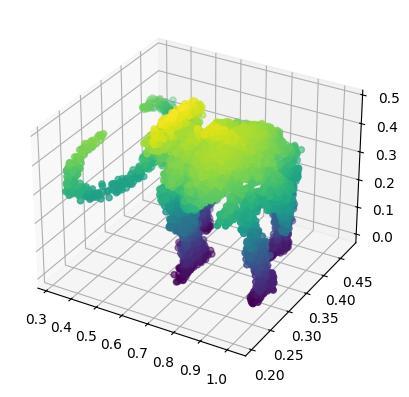

In [3]:
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.scatter(*noisy_mammoth.T, c=mammoth_color)

plt.show()

# Initialize dataset and model

In [4]:
data_set = torch.from_numpy(noisy_mammoth).float()

train_loader = DataLoader(
    data_set,
    batch_size=128,
    shuffle=True,
    drop_last=True
)

In [5]:
mrtg_ae = models.MRTGAutoencoder(input_dim=3, latent_dim=2,
                           r0=1.0, r1=0.01, r2=1.0, k=3.0,
                           lam_recon=1, lam_topo=5e-1, lam_geom=5e-1,
                           ae_loss=torch.nn.MSELoss(),
                           topo_reg=SignatureLoss(dimensions=[0,1]),
                           vr=VietorisRipsComplex(dim=1))

In [6]:
training_model = mrtg_ae

optimizer = optim.Adam(training_model.parameters(), lr=1e-3)

n_epochs = 100

progress = tqdm(range(n_epochs))

loss_values = []
ae_error_values = []
topo_error_values = []
geom_error_values = []


for epoch in progress:
    training_model.train()

    for batch, x in enumerate(train_loader):

        loss = training_model(x)
        ae = training_model.ae_error * training_model.lam_recon
        topo = training_model.topo_error * training_model.lam_topo
        geom = training_model.geom_error * training_model.lam_geom

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    progress.set_postfix(total_loss=loss.item(),
                         ae_error=ae.item(),
                         topo_error=topo.item(),
                         geom_error=geom.item()
                         )


    loss_values.append(loss.item())
    ae_error_values.append(ae.item())
    topo_error_values.append(topo.item())
    geom_error_values.append(geom.item())

100%|██████████| 100/100 [00:57<00:00,  1.75it/s, ae_error=0.00423, geom_error=0.235, topo_error=0.325, total_loss=0.564]


# Show embeddings

In [ ]:
Z = training_model.encode(data_set)
embed = Z.detach().numpy()

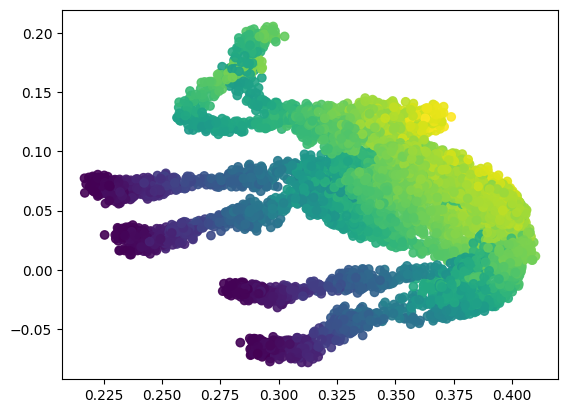

In [8]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(
    *embed.T,
    c = mammoth_color,
    alpha=0.9,
)

plt.show()

# Evaluation

In [11]:
metrics_mammoth = np.zeros((10, 6))
k_list = np.arange(10, 110, 10)

X_mammoth = noisy_mammoth
Z_mammoth = embed

for idx_k in tqdm(range(10)):
    k_m = k_list[idx_k]

    eval_mammoth = measures_optimized.MeasureCalculator(X=X_mammoth, Z=Z_mammoth, k_max=k_m)

    metircs = [eval_mammoth.density_kl_global_01(),
                eval_mammoth.knn_recall(k_m),
                eval_mammoth.trustworthiness(k_m),
                eval_mammoth.density_kl_global_100(),
                eval_mammoth.rmse(),
                eval_mammoth.spearman_metric()]
    
    metrics_mammoth[idx_k] = metircs



100%|██████████| 10/10 [03:28<00:00, 20.83s/it]


In [13]:
metrics_mammoth_mean = metrics_mammoth.mean(axis=0)

print('Mammoth metrics:')
print('Density KL 0.1:', metrics_mammoth_mean[0])
print('KNN Recall:', metrics_mammoth_mean[1])
print('Trustworthiness:', metrics_mammoth_mean[2])
print('Density KL 100:', metrics_mammoth_mean[3])
print('RMSE:', metrics_mammoth_mean[4])
print('Spearman:', metrics_mammoth_mean[5])

Mammoth metrics:
Density KL 0.1: 0.0027464128996096335
KNN Recall: 0.4940118162698412
Trustworthiness: 0.9646397428653224
Density KL 100: 1.4772983462567433e-08
RMSE: 0.1792786318829083
Spearman: 0.9662116072840554
